<a href="https://colab.research.google.com/github/aviralsomani/driv-face-classifier/blob/master/AviralSomani_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=d24e8cec0d98b1bf2034c45bc1a2bd45eb66c79ee24e02e3cd1ed0473fb13b28
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget
import os
from zipfile import PyZipFile
import shutil
import glob
import pandas as pd
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

tmp_dir = 'data/tmp'
img_dir = 'data/img'
trn_dir = 'data/trn'
val_dir = 'data/val'
uci_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00378/DrivFace.zip'

Using TensorFlow backend.


In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
def load_data():
  if not os.path.exists(img_dir):
    os.makedirs(tmp_dir)
    os.makedirs(img_dir)
    print("Downloading dataset to "+ tmp_dir)
    file = wget.download(uci_url, out=tmp_dir)
    print("\nUnzipping the files..")
    pzf = PyZipFile(file)
    pzf.extractall(tmp_dir)
    pzf = PyZipFile(tmp_dir + '/DrivFace/DrivImages.zip')
    pzf.extractall(tmp_dir)
    print("Moving files to " + img_dir)
    for file in os.listdir(tmp_dir + '/DrivImages'):
      shutil.move(tmp_dir+'/DrivImages/'+file, img_dir+'/'+file)
    shutil.move(tmp_dir + '/DrivFace/drivPoints.txt', img_dir + '/drivPoints.txt')
    shutil.rmtree(tmp_dir)

In [0]:
def move_train_val(train_dir, validation_dir, files, ratio):
  ind = 0
  for fname in files:
    src = os.path.join(img_dir, fname + '.jpg')
    t_dest = os.path.join(train_dir, fname + '')
    ind = ind + 1
    if ind < len(files)*ratio:
      shutil.move(os.path.join(img_dir, fname + '.jpg'),
                  os.path.join(train_dir, fname + '.jpg'))
    else:
      shutil.move(os.path.join(img_dir, fname + '.jpg'),
                  os.path.join(validation_dir, fname + '.jpg'))

In [0]:
import matplotlib.pyplot as plt
def showPlots(hist):
  acc = hist.history['acc']
  val_acc = hist.history['val_acc']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.ylim(0, 1)
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
  plt.plot(epochs, acc, 'bo', label='Training Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


In [0]:
def split_data(img_dir, trn_dir, val_dir, ratio):
  if not os.path.exists(trn_dir):
    os.makedirs(trn_dir)
    os.makedirs(val_dir)
    tff_dir = os.path.join(trn_dir, 'ff')
    tll_dir = os.path.join(trn_dir, 'll')
    tlr_dir = os.path.join(trn_dir, 'lr')
    os.makedirs(tff_dir)
    os.makedirs(tll_dir)
    os.makedirs(tlr_dir)
    vff_dir = os.path.join(val_dir, 'ff')
    vll_dir = os.path.join(val_dir, 'll')
    vlr_dir = os.path.join(val_dir, 'lr')
    os.makedirs(vff_dir)
    os.makedirs(vll_dir)
    os.makedirs(vlr_dir)
    df = pd.read_csv(img_dir + '/drivPoints.txt')['fileName']
    ff = [f for f in df if 'f' in f]
    ll = [f for f in df if 'll' in f]
    lr = [f for f in df if 'lr' in f]
    ind = 0
    move_train_val(tff_dir, vff_dir, ff, ratio)
    move_train_val(tll_dir, vll_dir, ll, ratio)
    move_train_val(tlr_dir, vlr_dir, lr, ratio)

In [0]:
load_data()


Unzipping the files..
Moving files to data/img


In [0]:
split_data(img_dir, trn_dir, val_dir, ratio=0.8)

In [0]:
from keras import layers
from keras import models

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', 
                        padding='same', 
                        input_shape=(64, 64, 3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', 
                        padding='same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3), activation='relu',
                        padding='same'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

In [0]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator

tr_dgen = ImageDataGenerator(rescale=1./255)
vl_dgen = ImageDataGenerator(rescale=1./255)
tr_gen = tr_dgen.flow_from_directory(trn_dir, target_size=(64, 64),
                                     batch_size=20, class_mode='categorical')

vl_gen = vl_dgen.flow_from_directory(val_dir, target_size=(64, 64),
                                     batch_size=20, class_mode='categorical')

Found 483 images belonging to 3 classes.
Found 123 images belonging to 3 classes.


In [0]:
hist = model.fit_generator(
    tr_gen,
    steps_per_epoch=100,
    epochs=30,
    validation_data=vl_gen,
    validation_steps=50)

Epoch 1/12
100/100 [==============================] - 19s 193ms/step - loss: 0.3890 - acc: 0.8934 - val_loss: 0.8073 - val_acc: 0.8956
Epoch 2/12
100/100 [==============================] - 13s 128ms/step - loss: 0.2325 - acc: 0.9224 - val_loss: 1.8752 - val_acc: 0.5040
Epoch 3/12
100/100 [==============================] - 13s 125ms/step - loss: 0.1253 - acc: 0.9524 - val_loss: 0.7369 - val_acc: 0.6027
Epoch 4/12
100/100 [==============================] - 12s 125ms/step - loss: 0.0775 - acc: 0.9715 - val_loss: 0.5503 - val_acc: 0.7185
Epoch 5/12
100/100 [==============================] - 13s 126ms/step - loss: 0.0435 - acc: 0.9808 - val_loss: 1.9541 - val_acc: 0.6663
Epoch 6/12
100/100 [==============================] - 13s 127ms/step - loss: 0.0343 - acc: 0.9876 - val_loss: 1.3207 - val_acc: 0.6652
Epoch 7/12
100/100 [==============================] - 13s 126ms/step - loss: 0.0295 - acc: 0.9928 - val_loss: 1.3079 - val_acc: 0.7801
Epoch 8/12
100/100 [==============================] - 1

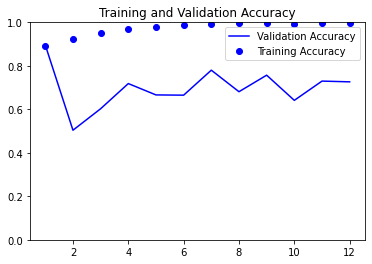

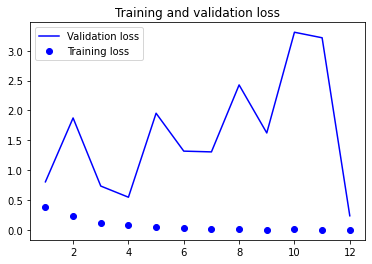

In [0]:
showPlots(hist)